In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/urban-air-pollution/SampleSubmission.csv
/kaggle/input/urban-air-pollution/Train.csv
/kaggle/input/urban-air-pollution/Test.csv


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

In [3]:
from tqdm.notebook import tqdm as tqdm_notebook

import datetime

In [4]:
import catboost
from catboost import CatBoostRegressor

from sklearn import preprocessing

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

In [6]:
import matplotlib.ticker as tkr
import math
from matplotlib.colors import SymLogNorm
from itertools import product 
from scipy.stats import pearsonr

In [7]:
train = pd.read_csv("../input/urban-air-pollution/Train.csv")
train = train.sort_values(by='Date').reset_index(drop=True)
train.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.5,92,11.0,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,R8CIARR X 2020-01-02,2020-01-02,R8CIARR,210.0,137.0,489.0,73982.3,105,7.6,92.900002,...,17.114866,-164.471834,68.996603,1838.009277,3136.416992,0.007221,-98.006920,18.329800,-164.326263,69.203545


In [8]:
#train = train.drop(["target_min", "target_max", "target_variance", "target_count"], axis=1)

In [9]:
test = pd.read_csv("../input/urban-air-pollution/Test.csv")
test = test.sort_values(by='Date').reset_index(drop=True)
test.head(2)

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,0OS9LVX X 2020-01-02,2020-01-02,0OS9LVX,11.600000,30.200001,0.004090,14.656824,3.956377,0.712605,0.000053,...,1.445658,-95.984984,22.942019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QLO2NZF X 2020-01-02,2020-01-02,QLO2NZF,3.777778,46.166667,0.001124,-5.462066,0.393044,-1.141839,0.000651,...,15.559309,-167.937679,63.824188,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
ss = pd.read_csv("../input/urban-air-pollution/SampleSubmission.csv")
ss.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,0
1,0OS9LVX X 2020-01-03,0
2,0OS9LVX X 2020-01-04,0
3,0OS9LVX X 2020-01-05,0
4,0OS9LVX X 2020-01-06,0


In [11]:
train.shape, test.shape, ss.shape,

((30557, 82), (16136, 77), (16136, 2))

## ***Check for missing values and the data types of each attribute***

# **Visualizing the missing values**
With the help of heatmap, we can see the amount of data that is missing from the attribute. With this, we can make decisions whether to drop these missing values or to replace them. Usually dropping the missing values is not advisable but sometimes it may be helpful too.

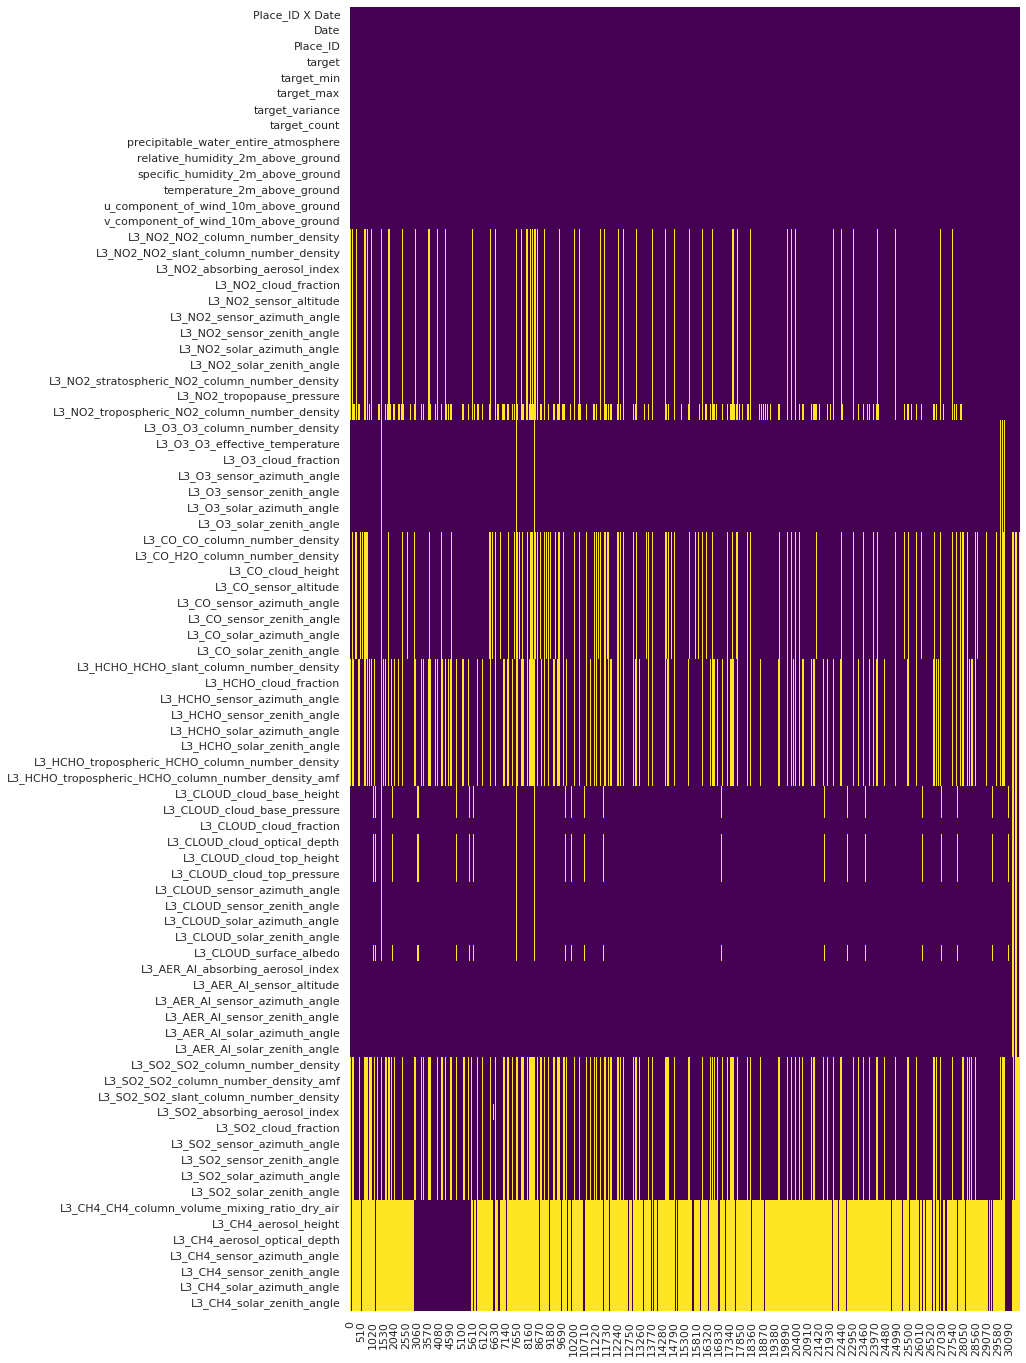

In [12]:
plt.figure(figsize=(12,24))
sns.heatmap(train.isnull().T,cbar=False,cmap='viridis')
plt.savefig("heatmap.png")

We can observe that there are many missing values in some columns while other columns have fewer missing values. There are also some periods where no data were recorded, and in others, the data was collected daily.

NB: Take this information into consideration when filling in the missing values.

Now let us apply domain knowledge and ask the questions which will affect the daily mean concentration which is the "target".

# **Asking Analytical Questions and Visualizations**
This is the most important step in EDA. This step will decide how much can you think as an Analyst. This step varies from person to person in terms of their questioning ability. Try to ask questions related to independent variables and the target variable. For example – how "L3_CH4_" features will affect the "target"?

# **How does some features affect the "target"?**

In [13]:
train["L3_CH4_solar_zenith_angle"].isnull().sum()/train.shape[0]

0.8104525967863337

In [14]:
from scipy import stats
for col in train.columns[-7:]:
    print(col)
    print("missing values:", train[col].isnull().sum()/train.shape[0]) 
    print(stats.pearsonr(train[col].fillna(0), train['target']), "\n")

L3_CH4_CH4_column_volume_mixing_ratio_dry_air
missing values: 0.8104525967863337
(0.10822554862069128, 2.8295553477294324e-80) 

L3_CH4_aerosol_height
missing values: 0.8104525967863337
(0.10734650877772625, 5.3372268690140456e-79) 

L3_CH4_aerosol_optical_depth
missing values: 0.8104525967863337
(0.09570334074943945, 4.2336318110638644e-63) 

L3_CH4_sensor_azimuth_angle
missing values: 0.8104525967863337
(0.0087217535229368, 0.12736437867609526) 

L3_CH4_sensor_zenith_angle
missing values: 0.8104525967863337
(0.08102852609811281, 1.1028792205657961e-45) 

L3_CH4_solar_azimuth_angle
missing values: 0.8104525967863337
(-0.11934575881872794, 2.50054473140629e-97) 

L3_CH4_solar_zenith_angle
missing values: 0.8104525967863337
(0.09370557925755278, 1.476220250728011e-60) 



(array([2302.,  181.,   16.,  233.,   37., 2921.,    6.,    5.,    4.,
          87.]),
 array([-1.79947422e+02, -1.43971346e+02, -1.07995269e+02, -7.20191926e+01,
        -3.60431160e+01, -6.70394122e-02,  3.59090372e+01,  7.18851138e+01,
         1.07861190e+02,  1.43837267e+02,  1.79813344e+02]),
 <BarContainer object of 10 artists>)

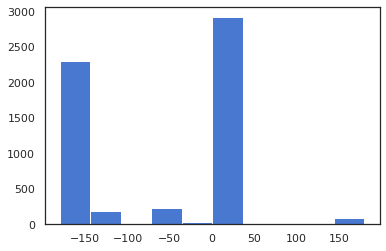

In [15]:
plt.hist(train["L3_CH4_solar_azimuth_angle"])

It's obvous that the features "L3_CH4_" have a sum of 81% missing values. But if we calculate their p-values vs the "target" variable, we will get very low values, which mean that those columns aren't Normal (Gaussian) distributed, it's also very clear in the histograme. Exept for the "L3_CH4_sensor_azimuth_angle" feature that present a heigher p-value ".12" (typically >= .05) .

NB: So keep this in mind if you want to use these features. 

Note:
Do not use 0 before the decimal point for the statistical value p as it cannot equal 1, in other words, write p = .001 instead of p = 0.001.
Please pay attention to issues of italics (p is always italicized) and spacing (either side of the = sign).
p = .000 (as outputted by some statistical packages such as SPSS) is impossible and should be written as p < .001.
The opposite of significant is "nonsignificant", not "insignficant".
Why the p-value is not enough
A lower p-value is sometimes interpreted as meaning there is a stronger relationship between two variables. However, statistical significance means that it is unlikely that the null hypothesis is true (less than 5%).

To understand the strength of the difference between two groups (control vs. experimental) a researcher needs to calculate the effect size.

Often we would like to customize our visualization so that it is more informative and suitable to our need. Let us see a customized heatmap with Seaborn.

For that we use pandas pivot to reshape the data such that we want Place_ID as rows and Date on columns, we specify index and columns variables accordingly.

NB: To show all places of the dataset, it will be in a squished way. So let's visualise just the first 10 places of the trainset, so that it is not squished and we can see some places ids. Add more rows and see how you can interpret it...

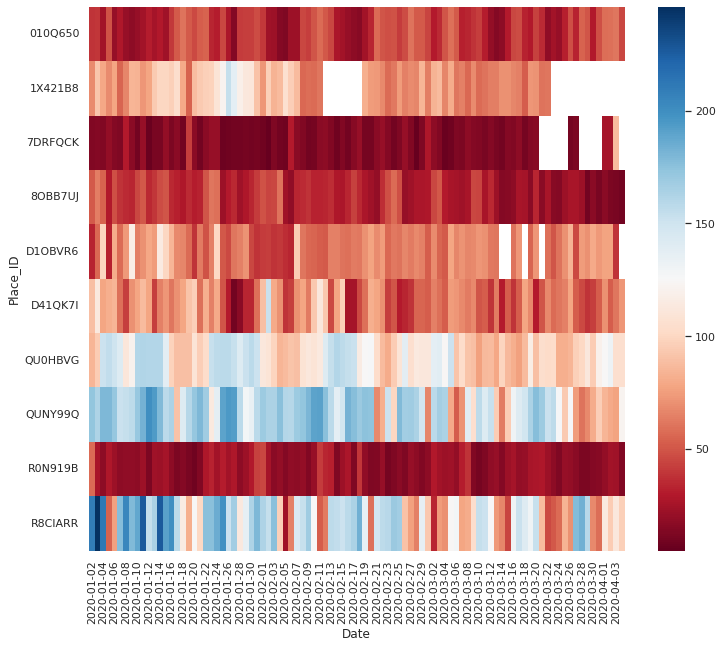

In [16]:
data = train.loc[train["Place_ID"].isin(train["Place_ID"].unique()[:10])]

plt.figure(figsize=(12,10))

# pandas pivot
heatmap1_data = pd.pivot_table(data, values='target', 
                     index=['Place_ID'], 
                     columns='Date')
sns.heatmap(heatmap1_data, cmap="RdBu")
plt.savefig("pivot.png")

We can see that our heatmap shows target’s expectancy values over time (Date). And automatically, Seaborn’s heatmap function is using all Places of the selecte data and labels the Place_ID on rows.

This heatmap has given us great insights into the data, with some positive correletion and negative ones, also some correlations are heigher than others: 

\* We can see that the daily mean concentration which is the "target", in "ORYZQUU" and "OPP73FZ", improved between 20/01/2020 and 20/02/2020, with "ORYZQUU" place doing much better than "OPP73FZ" place and so on.
    
\* As we can see that the "target" in "OHYPVIN" and "ODPWHXB" improved sucessively vor more than 3 days.

NB: Given those informations you can try to use expanding/rolling to extract new features.

# Combine the train and test datasets

Let us combine the training and testing datasets to minimize the replication of the same instructions.

In [17]:
train["train"]=1
test["train"]=0
train_test = pd.concat([train,test]).sort_values(by='Date').reset_index(drop=True)
train_test.head(1)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,train
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.5,92.0,11.0,60.200001,...,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118,1


**To use date features, converting Date column to datetime.**

In [18]:
train_test['Date'] = pd.to_datetime(train_test['Date'], format='%Y-%m-%d')

In [19]:
(train_test["Date"].max() - train_test["Date"].min()).days +1

94

In [20]:
places_count = Counter(train_test["Place_ID"])

places_count['R8CIARR'], places_count['1Y0S7TZ'], places_count['MJSB8K5']

(94, 49, 7)

In [21]:
places_count.most_common()[-11:]

[('LKE9VQB', 41),
 ('5PXQINB', 35),
 ('8CPKUI4', 35),
 ('HYKM9JF', 29),
 ('S91MBTB', 29),
 ('DES3SOP', 26),
 ('RG3VKJB', 25),
 ('M2NF5RJ', 24),
 ('6KAHP8X', 12),
 ('MJSB8K5', 7),
 ('5IUK9TG', 3)]

In [22]:
train_test.shape

(46693, 83)

In [23]:
values = ['6KAHP8X', 'MJSB8K5', '5IUK9TG']
  
train_test = train_test.drop(train_test.loc[train_test["Place_ID"].isin(values)].index)

In [24]:
from itertools import cycle    

N = len(train_test['Place_ID'].unique()) * len(train_test['Date'].unique())

places = cycle(train_test['Place_ID'])
dates = cycle(train_test['Date'])


data = {"Place_ID": [next(places) for j in range(N)], "Date": [next(dates) for j in range(N)]}
data = pd.DataFrame(data)
data["Place_ID X Date"] = list(map(lambda x: str(x[0] + " X " + str(x[1])[:10]), data.values))
data.head(2)

,Place_ID,Date,Place_ID X Date
0,010Q650,2020-01-02,010Q650 X 2020-01-02
1,C3ECRX8,2020-01-02,C3ECRX8 X 2020-01-02


In [25]:
train_test = train_test.merge(data,on=['Place_ID', 'Date', 'Place_ID X Date'], how='outer')

In [26]:
train_test.isnull().sum()

Place_ID X Date                    0
Date                               0
Place_ID                           0
target                         16719
target_min                     16719
                               ...  
L3_CH4_sensor_azimuth_angle    39445
L3_CH4_sensor_zenith_angle     39445
L3_CH4_solar_azimuth_angle     39445
L3_CH4_solar_zenith_angle      39445
train                              0
Length: 83, dtype: int64

# **Replacing the missing values**
We will be replacing these missing values with mean because the number of missing values is less(we can use median too).

NB: You can choose from the below methods or try your own method to fill these values...

In [27]:
nan_cols = train_test.columns[train_test.isnull().any()].tolist()

for col in nan_cols:
    
    # You can try filling the missing values by zero or the median... and judge with the final submission
    #train[col].fillna(train[col].mean(), inplace=True) 
    #test[col].fillna(test[col].mean(), inplace=True)
    
    """while train[col].isnull().sum()>0:
        train[col].fillna(train[["Place_ID", col]].groupby(["Place_ID"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True) 

    while test[col].isnull().sum()>0:
        test[col].fillna(test[["Place_ID", col]].groupby(["Place_ID"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True) 
    """
    while train_test[col].isnull().sum()>0:
  
        train_test[col].fillna(train_test[["Place_ID", col]].groupby(["Place_ID"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True) 

train.isnull().sum().sum(), test.isnull().sum().sum(), train_test.isnull().sum().sum()

(388262, 215137, 0)

### Compare different scalers on data with outliers

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


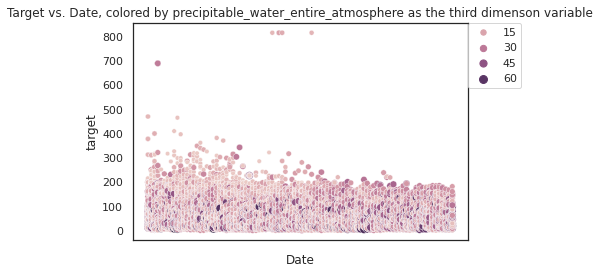

In [28]:
data = train_test.sort_values(by="Date") # data = train[train['Place_ID'] == '010Q650'].sort_values(by="Date")

ax = sns.scatterplot(x="Date", y="target",
                hue="precipitable_water_entire_atmosphere", 
                size="precipitable_water_entire_atmosphere",
                data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
# control x and y limits
#plt.ylim(0, 750)

# Put the title and the legend out of the figure
plt.title("Target vs. Date, colored by precipitable_water_entire_atmosphere as the third dimenson variable")
plt.legend(bbox_to_anchor=(1.0005, 1), loc=2, borderaxespad=0.)

We can see that most of the target values lies between 0-300 and they hadn't directly been affected by the Date, however there values between 300-800 could be considered as outliers.

So let’s use a boxplot to check if those values are outliers or remain between the .

<AxesSubplot:>

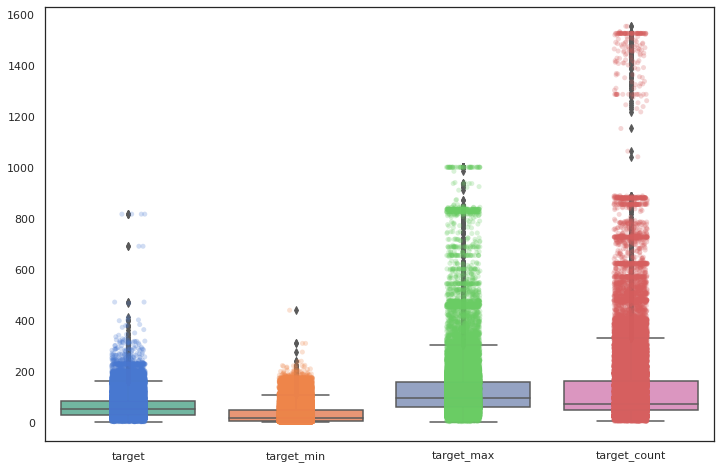

In [29]:
data=train_test[["target", "target_min", "target_max", "target_count"]]

plt.figure(figsize=(12,8))
sns.boxplot(data=data, palette="Set2")
sns.stripplot(alpha=0.25, data=data)

After dealing with the outliers, let us check the correlation between different variables, this will give us a roadmap on how to proceed further.

NB: Hire I checked just the columns that doesn't have null values, it's up to you to check the others as well...

In [30]:
dfX = train_test.copy()
col = dfX['target'].values.reshape(-1, 1)

scalers = [
    #('Unscaled data', X),
    ('standard scaling', StandardScaler()),
    ('min-max scaling', MinMaxScaler()),
    ('max-abs scaling', MaxAbsScaler()),
    ('robust scaling', RobustScaler(quantile_range=(25, 75))),
    ('quantile transformation (uniform pdf)', QuantileTransformer(output_distribution='uniform')),
    ('quantile transformation (gaussian pdf)', QuantileTransformer(output_distribution='normal')),
    ('sample-wise L2 normalizing', Normalizer())
]

for scaler in scalers:
    dfX[scaler[0]] = scaler[1].fit_transform(col)

In [31]:
orig = train_test['target']
orig_mean = orig.mean()
bins = 200
alpha=0.5

def plot_experiment(name):
    normalized = dfX[name]
    plt.figure(figsize=(10,5))
    plt.hist(orig, bins, alpha=alpha, label='Original')
    plt.axvline(orig_mean, color='k', linestyle='dashed', linewidth=1)
    plt.xlim(-5, 250)
    
    plt.hist(normalized, bins, alpha=2*alpha, label=name)
    plt.axvline(normalized.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend(loc='upper right')
    plt.show()
    
    plt.figure(figsize=(5,5))
    g = sns.jointplot(x="target", y=name, data=dfX, kind='hex', ratio=3)
    #sns.violinplot(x='target', data=dfX, )
    #sns.violinplot(x='standard scaling', data=dfX)
    #plt.boxplot(dfX['target'])
    #plt.boxplot(dfX['standard scaling'])
    plt.show()

### StandardScaler
StandardScaler removes the mean and scales the data to unit variance. However, the outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values.

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

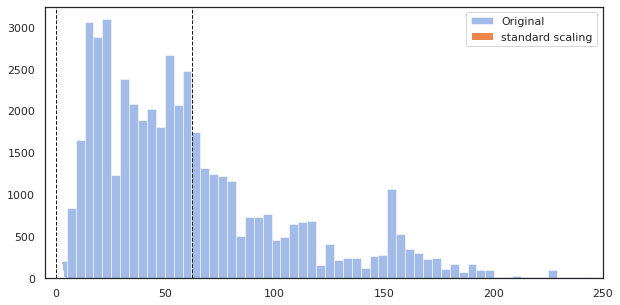

<Figure size 360x360 with 0 Axes>

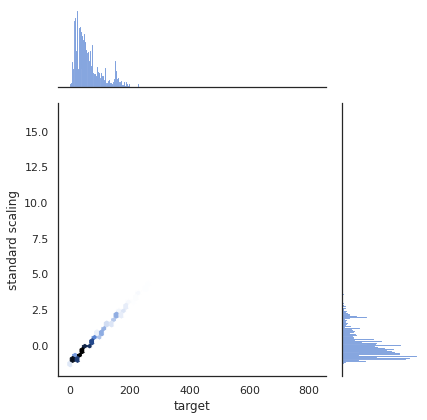

In [32]:
plot_experiment('standard scaling')

### MinMaxScaler
MinMaxScaler rescales the data set such that all feature values are in the range [0, 1].

As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers.

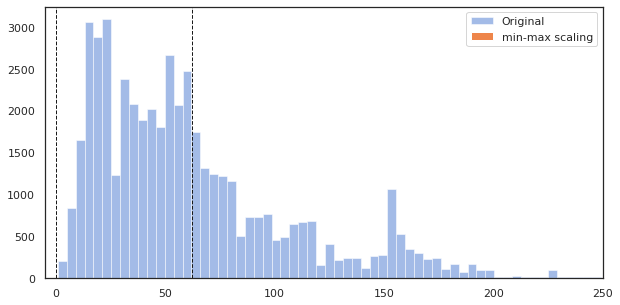

<Figure size 360x360 with 0 Axes>

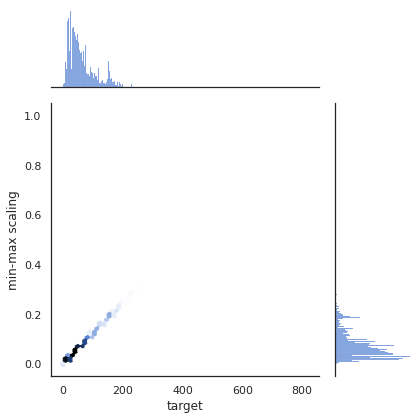

In [33]:
plot_experiment('min-max scaling')

### MaxAbsScaler
MaxAbsScaler differs from the previous scaler such that the absolute values are mapped in the range [0, 1]. On positive only data, this scaler behaves similarly to MinMaxScaler and therefore also suffers from the presence of large outliers.

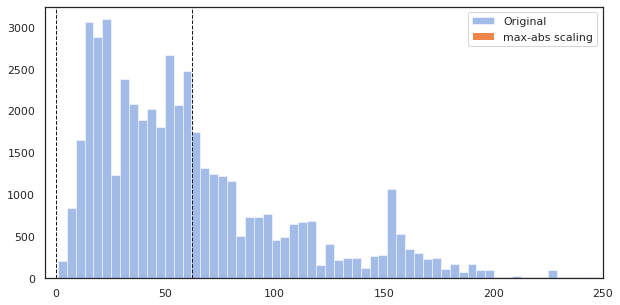

<Figure size 360x360 with 0 Axes>

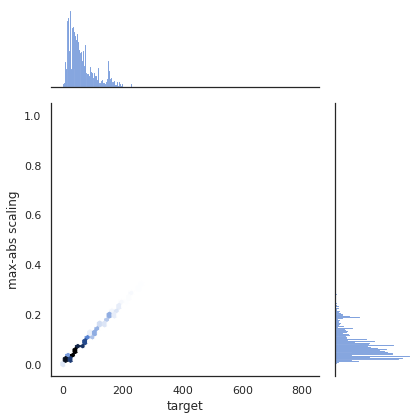

In [34]:
plot_experiment('max-abs scaling')

### RobustScaler
Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar: most of the transformed values lie in a [-2, 3] range. Note that the outliers themselves are still present in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required (see below).

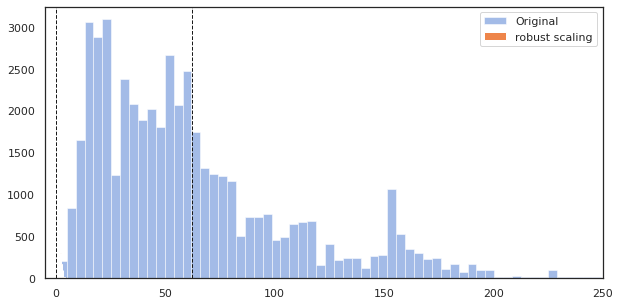

<Figure size 360x360 with 0 Axes>

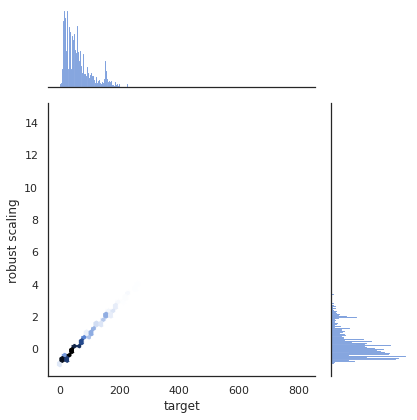

In [35]:
plot_experiment('robust scaling')

### QuantileTransformer (uniform output)
QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1], even the outliers which cannot be distinguished anymore from the inliers.

As RobustScaler, QuantileTransformer is robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

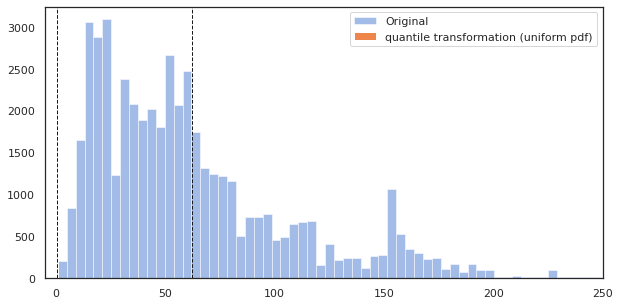

<Figure size 360x360 with 0 Axes>

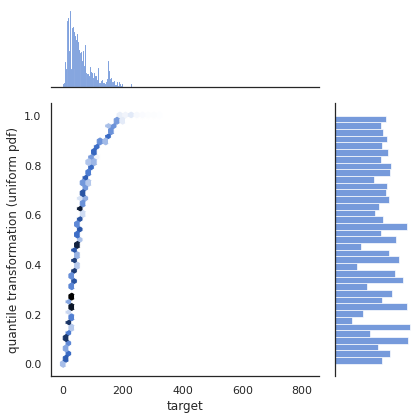

In [36]:
plot_experiment('quantile transformation (uniform pdf)')

### QuantileTransformer (Gaussian output)¶
QuantileTransformer has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values.

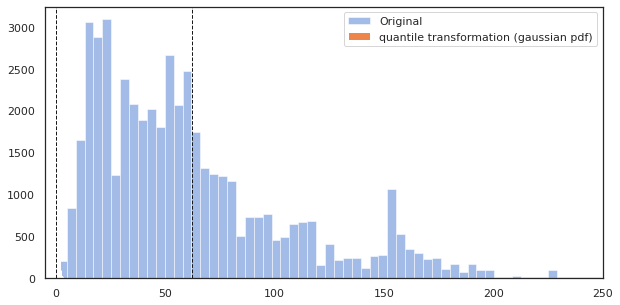

<Figure size 360x360 with 0 Axes>

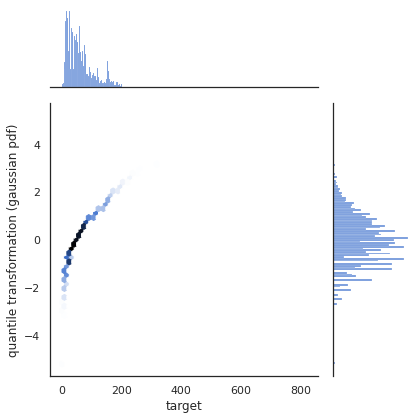

In [37]:
plot_experiment('quantile transformation (gaussian pdf)')

### Normalizer
The Normalizer rescales the vector for each sample to have unit norm, independently of the distribution of the samples. It can be seen on both figures below where all samples are mapped onto the unit circle. In our example the two selected features have only positive values; therefore the transformed data only lie in the positive quadrant. This would not be the case if some original features had a mix of positive and negative values.

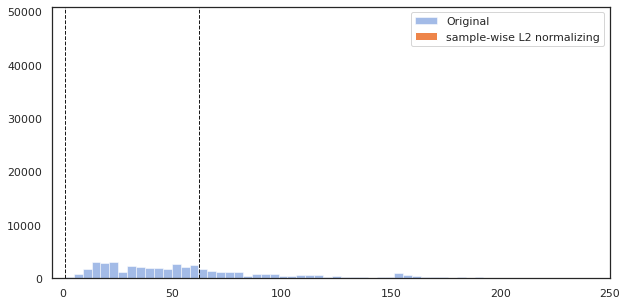

<Figure size 360x360 with 0 Axes>

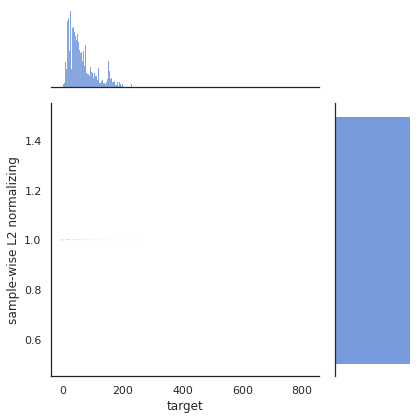

In [38]:
plot_experiment('sample-wise L2 normalizing')

In [39]:
dfX[['target', 'sample-wise L2 normalizing']].sample(20)

,target,sample-wise L2 normalizing
34186,34.0,1.0
12909,107.0,1.0
36973,42.0,1.0
45172,59.0,1.0
45907,80.0,1.0
36464,18.0,1.0
18684,14.0,1.0
38051,41.0,1.0
40188,36.0,1.0
44790,53.0,1.0


# Coefficient of correlation

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

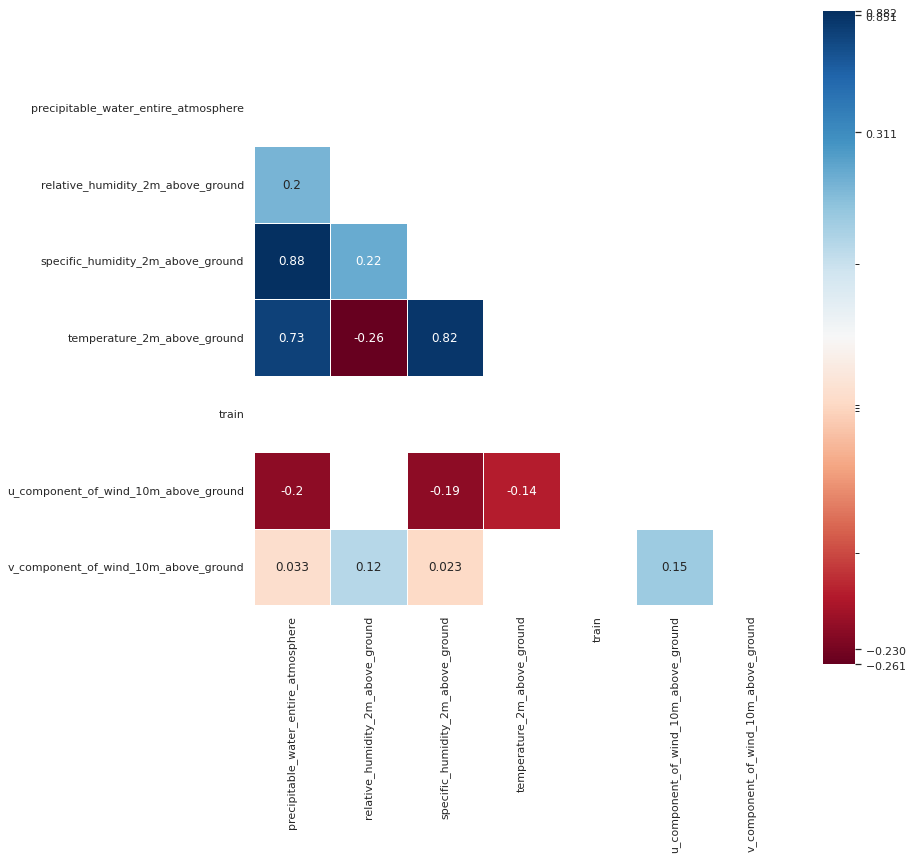

In [40]:
data = train[train.columns.difference(nan_cols)]

plt.figure(figsize=(12,12))

#sns.heatmap(train[nan_cols[:34]].corr(),cbar=True,annot=False,cmap='Purples')

formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

# Compute the correlation matrix
corr = data.corr()
corr2 = corr.stack()
corr2 = corr2[corr2.index.get_level_values(0) != corr2.index.get_level_values(1)]

vmax=corr2.values.max()
vmin=corr2.values.min()
center = (vmax+vmin)/2
log_norm = SymLogNorm(linthresh=center/10, linscale=center/10, vmin=vmin, vmax=vmax)
 
cbar_ticks = [vmin, vmin+center/10, center, vmax-center/10, vmax]

# Generate a mask for the upper triangle
"""mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True"""
mask = np.zeros_like(corr, dtype=bool)
pvals = corr.copy()

# Produce a mask of correlation vith p-values
for i, j in product(corr.columns, corr.columns):
    _, pvals.loc[i,j] = pearsonr(data[i], data[j])
siglevel=.05

mask[pvals > siglevel ] = True
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask=mask, square=True, cmap='RdBu', linewidths=.5, cbar=True,annot=True,
                 vmax=vmax, vmin=vmin, norm=log_norm, cbar_kws={"ticks": cbar_ticks, "format": formatter}, center=center)
#ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)

In the above graph, you can see that the correlation range is from -0.26 to 0.88, where the blue squares show a positive correlations (that is as one increases so does the other), the red squares show a negative correlation (instead of both increasing one variable will decrease as the other increases), and the orange squares show no relation between the variables on each axis (means there is no linear trend between the two variables it changes randomly independently).

## Feature extraction

In [41]:
def rolling_expanding(dataset):
    window_sizes= [3, 7, 21]#, 30, 60, 75, 100]
    data = dataset.drop(["Place_ID", "Date"])
    for exp_rol in data.columns: 
        for window in window_sizes:
            data[str(exp_rol) + "rolling_median_" + str(window)] = data[exp_rol].rolling(window=window, min_periods = 1).median().fillna(method='backfill')
            data[str(exp_rol) + "expanding_mean_" + str(window)] = data[exp_rol].expanding(window).mean().fillna(method='backfill')
    pd.Series(data.sum(), name='sum').add_suffix('_sum')

In [42]:
train_test['placeID_freq'] = train_test['Place_ID'].map(train_test['Place_ID'].value_counts())

In [43]:
for i in [2,3,7,10,21,30]:
     
    train_test[f'prev_target_{i}'] = np.nan
    train_test[f'next_target_{i}'] = np.nan
    train_test[f'prev_target_{i}'].fillna(train_test.groupby(["Place_ID"]).shift(i).fillna(method='ffill')["target"], inplace=True)
    train_test[f'next_target_{i}'].fillna(train_test.groupby(["Place_ID"]).shift(-i).fillna(method='bfill')["target"], inplace=True)

In [44]:
for i in tqdm_notebook([2,3,7,10,21,30]):
    train_test[f'expand_target_forward_{i}'] = np.nan
    train_test[f'expand_target_backward_{i}'] = np.nan
    train_test[f'expand_target_forward_{i}'].fillna(train_test.groupby(by='Place_ID')["target"].shift(i).expanding().mean().fillna(method='ffill'), inplace=True)
    train_test[f'expand_target_backward_{i}'].fillna(train_test.groupby(by='Place_ID')["target"].shift(-i).expanding().mean().fillna(method='bfill'), inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [45]:
from functools import partial
import re
import calendar

def add_cyclic_datepart(df, field_name:str, prefix:str=None, drop:bool=True, time:bool=False, add_linear:bool=False):
    "Helper function that adds trigonometric date/time features to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    series = field.apply(partial(cyclic_dt_features, time=time, add_linear=add_linear))
    columns = [prefix + c for c in cyclic_dt_feat_names(time, add_linear)]
    df_feats = pd.DataFrame([item for item in series], columns=columns, index=series.index)
    for column in columns: df[column] = df_feats[column]
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df
def make_date(df, date_field:str):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a
def cyclic_dt_features(d, time:bool=True, add_linear:bool=False):
    "Calculate the cos and sin of date/time cycles."
    tt,fs = d.timetuple(), [np.cos, np.sin]
    day_year,days_month = tt.tm_yday, calendar.monthrange(d.year, d.month)[1]
    days_year = 366 if calendar.isleap(d.year) else 365
    rs = d.weekday()/7, (d.day-1)/days_month, (d.month-1)/12, (day_year-1)/days_year
    feats = [f(r * 2 * np.pi) for r in rs for f in fs]
    """if time and isinstance(d, datetime) and type(d) != date:
        rs = tt.tm_hour/24, tt.tm_hour%12/12, tt.tm_min/60, tt.tm_sec/60
        feats += [f(r * 2 * np.pi) for r in rs for f in fs]"""
    """if add_linear:
        if type(d) == date: feats.append(d.year + rs[-1])
        else:
            secs_in_year = (datetime(d.year+1, 1, 1) - datetime(d.year, 1, 1)).total_seconds()
            feats.append(d.year + ((d - datetime(d.year, 1, 1)).total_seconds() / secs_in_year))"""
    return feats
def cyclic_dt_feat_names(time:bool=True, add_linear:bool=False):
    "Return feature names of date/time cycles as produced by `cyclic_dt_features`."
    fs = ['cos','sin']
    attr = [f'{r}_{f}' for r in 'weekday day_month month_year day_year'.split() for f in fs]
    if time: attr += [f'{r}_{f}' for r in 'hour clock min sec'.split() for f in fs]
    if add_linear: attr.append('year_lin')
    return attr

In [46]:
for i in tqdm_notebook(range(1, 45)):
    c = 'Date' + str(i+1)
    train_test[c] = train_test['Date']  + datetime.timedelta(days=i)
    _ = add_cyclic_datepart(train_test, c, prefix = c)

  0%|          | 0/44 [00:00<?, ?it/s]

In [47]:
import gc
del train
del test
del data
gc.collect()

41

features = [c for c in train_test.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID', 'target_max', 'target']]


for i in tqdm_notebook(range(1, 7)): # range(1, 11)
    tmp = train_test.groupby('Place_ID')[features].shift(i) 
    tmp_diff_prev = train_test[features] - tmp
    tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
    tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
    train_test = pd.concat([train_test, tmp, tmp_diff_prev], axis=1)
    
    tmp = train_test.groupby('Place_ID')[features].shift(-i) 
    tmp_diff_next = train_test[features] - tmp
    tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
    tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
    train_test = pd.concat([train_test, tmp, tmp_diff_next], axis=1)

In [48]:
for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    train_test[attr] = getattr(train_test['Date'].dt.isocalendar(), attr)
train_test['is_weekend'] = (train_test['dayofweek'] >= 5)*1
train_test['fortnight'] = train_test['day']%15
train_test['which_fortnight'] = train_test['day']//15

add_cyclic_datepart(train_test, "Date", prefix = "Current_Date_")

AttributeError: 'DataFrame' object has no attribute 'month'

In [ ]:
le_place = preprocessing.LabelEncoder()
train_test["Place_ID"] = le_place.fit_transform(train_test["Place_ID"])

le_placeXdate = preprocessing.LabelEncoder()
train_test["Place_ID X Date"] = le_placeXdate.fit_transform(train_test["Place_ID X Date"])

le_date = preprocessing.LabelEncoder()
train_test["Date"] = le_date.fit_transform(train_test["Date"])

In [ ]:
data = train_test[train_test.columns.difference(["Place_ID", "Date", "Place_ID X Date", "train"])]
data_cols = data.columns

In [ ]:
...
# perform a normal quantile transform of the dataset
trans = QuantileTransformer(output_distribution='normal')#(n_quantiles=100, output_distribution='normal')
data = trans.fit_transform(data)
data = pd.DataFrame(data, columns= data_cols)
data[["Place_ID", "Date", "Place_ID X Date", "train"]] = train_test[["Place_ID", "Date", "Place_ID X Date", "train"]].values
data

In [ ]:
train_test = data
del data

In [ ]:
train = train_test.loc[train_test["train"]==1].reset_index(drop=True).drop("train", axis=1)
test = train_test.loc[train_test["train"]==0].reset_index(drop=True).drop("train", axis=1)

In [ ]:
list_targets = ['target_count', 'target_min',  'target_variance','target_max', "target"]
drop_features = ['target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID', 'target_max', 'target']

aux_X =  train.drop(drop_features, axis=1) # train.drop(list_targets, axis=1)
#aux_y = train[["target_min", "target_max", "target_variance", "target_count"]].values

X = train.drop("target", axis=1) # train.drop(["target"], axis=1)
y = train["target"]

In [ ]:
#train.describe().T

In [ ]:
i_train = int(aux_X.shape[0]/6.5)

X_train = aux_X.iloc[i_train:]
y_train = y.iloc[i_train:]
X_valid = aux_X.iloc[:i_train]
y_valid = y.iloc[:i_train]
        
params = {'learning_rate': 0.00575, 
          'depth': 9, 
          'l2_leaf_reg': 2, 
          'loss_function': 'RMSE', #'MultiRMSE'
          'eval_metric': 'RMSE', #'MultiRMSE'
          'task_type':"GPU",
          'devices':'0:1',
         }
aux_model = CatBoostRegressor(**params,
                                  iterations=53579)
#aux_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)
aux_model.fit(aux_X,y,verbose=0)

In [ ]:
aux_preds = aux_model.predict(test[aux_X.columns])

In [ ]:
aux_preds

In [ ]:
test[["target_min", "target_max", "target_variance", "target_count"]] = aux_preds

In [ ]:
aux_model.fit(X, y, verbose=0)
preds = aux_model.predict(test[X.columns])

In [ ]:
ss = pd.DataFrame(columns=[ "Place_ID X Date", "target"])
ss["Place_ID X Date"]= le_placeXdate.inverse_transform(test["Place_ID X Date"])
ss["target"] = aux_preds
ss.to_csv("submission22.csv", index=False)
ss

In [ ]:
ss.min(), ss.max()

In [ ]:
_ = plt.figure(figsize=(10, 10))
fi = pd.Series(index=aux_X.columns, data=aux_model.get_feature_importance())
_ = fi.sort_values()[-50:].plot(kind='barh')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [ ]:
kfolds = 3
tss = KFold(n_splits=kfolds, shuffle=True, random_state=1)

seeds = 7 # the number of seeds to average
 
seed_valid_preds = []
seed_test_preds = 0
seed_scores = []

features = aux_X.columns.difference(['target']) 

for s in range(seeds):
    fold_valid_preds = {}
    fold_test_preds = []
    fold_scores = []
    seed_valid_ids = []

    for fold, (i_train, i_test) in enumerate(tss.split(X)):
        fold_test_pred_kfold = 0
        X_train = X.iloc[i_train]
        y_train = y.iloc[i_train]
        #y_train = enc.transform(y_train.values.reshape(-1, 1)).toarray()

        X_valid = X.iloc[i_test]
        y_valid = y.iloc[i_test]
        #y_valid = enc.transform(y_valid.values.reshape(-1, 1)).toarray()

        fold_valid_ids = X_valid["Place_ID X Date"].values.tolist()
        seed_valid_ids += fold_valid_ids

        X_train = X_train[features]
        X_valid = X_valid[features]
        
        params = {'depth': 9,
                  'learning_rate': 0.0095,
                  'l2_leaf_reg': 7,
                  'random_strength': 2,
                  'min_data_in_leaf': 1} 
        
                
        model = CatBoostRegressor(**params,
                                  iterations=13579,#20000
                                  bootstrap_type='Bayesian',
                                  boosting_type='Plain',
                                  loss_function='RMSE',
                                  eval_metric='RMSE', # 'SMAPE' only on CPU
                                  task_type="GPU",
                                  devices='0:1',
                                  random_seed=s) 
        

        model.fit(X_train,
                  y_train,
                  early_stopping_rounds=199,#200
                  eval_set=[(X_valid, y_valid)],
                  verbose=0)
        
        

        fold_valid_pred = model.predict(X_valid)
        X_test = test[features]
        fold_test_pred = model.predict(X_test)
        
        fold_valid_preds.update(dict(zip(fold_valid_ids, fold_valid_pred)))
        fold_test_pred_kfold += fold_test_pred
        fold_score = mean_squared_error(fold_valid_pred, y_valid, squared=False)############################################
        ######################fold_score = np.mean(np.abs(fold_valid_pred - y_valid) / ((np.abs(y_valid) + np.abs(fold_valid_pred)) / 2)) * 100
        
        fold_scores.append(fold_score)
        print(f'Seed {s} fold {fold} RMSE: {fold_score}')
    
     
    
    fold_test_pred_kfold /= kfolds
    print(f'Seed {s} RMSE {np.mean(fold_scores)}')
    
    seed_valid_pred = np.array(list(fold_valid_preds.values()))
    seed_test_preds += np.column_stack(fold_test_pred_kfold) 
     
    
    """seed_valid_preds.append(seed_valid_pred)
    seed_test_preds.append(seed_test_pred)"""
    
    seed_score = np.mean(fold_scores)
    seed_scores.append(seed_score)
    
print(f'RMSE of {s+1} seeds: {np.mean(seed_scores)}')
# seed_test_preds /= seeds 

In [ ]:
seed_test_preds[0]

In [ ]:
ss["Place_ID X Date"] = le_placeXdate.inverse_transform(test["Place_ID X Date"])
ss["target"] = seed_test_preds[0]
ss.to_csv("submission14.csv", index=False)
ss.min(), ss.max()

In [ ]:
ss